# Data augmentation techniques for NLP
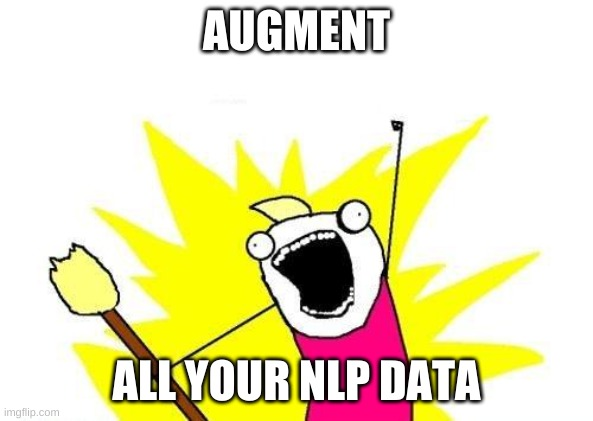



The training size will impact the performace of a model heavily, this notebook will discuss the possibilities of performing data augmentation on a NLP dataset. Data augmentation techniques are used to generate additional samples. Data augmentation is already standard practice in computer vision projects, but can also be leveraged in multilingual NLP problems.  We'll use a limited trainingset to simulate a real-world use case, where we often are constrained by the size of the available data. We'll focuss on using backtranslation and word-embedding substitution as a data augmentation technique.






In [ ]:
!pip install -q transformers sentencepiece datasets tokenizers torch nltk
!pip install -q nlpaug
!pip install fairseq>=0.9.0 sacremoses>=0.0.43 fastBPE>=0.1.0

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import re
import numpy as np
from nltk import tokenize
import nltk
from datasets import load_dataset, concatenate_datasets, load_from_disk
from abc import ABC
from datasets import load_metric
from transformers import TrainingArguments, Trainer, TrainerCallback
import gc
import torch
import pandas as pd 
import plotly.graph_objects as go
import nlpaug.flow as naf
import nlpaug.augmenter.word as naw
import logging


In [ ]:
!mkdir logs
!mkdir datasets
logging.basicConfig(level=logging.INFO)


In [ ]:
logging.info('Downloading omw and punkt')
import nltk
nltk.download('omw')
nltk.download('punkt')

In [ ]:
logging.info('Downloading pipelines for backtranslation')

trans_pipeline_en_nl = pipeline(
    task='translation_en_to_nl',
    model='Helsinki-NLP/opus-mt-en-nl',
    tokenizer='Helsinki-NLP/opus-mt-en-nl',
    device=0)
trans_pipeline_nl_fr = pipeline(
    task='translation_nl_to_fr',
    model='Helsinki-NLP/opus-mt-nl-fr',
    tokenizer='Helsinki-NLP/opus-mt-nl-fr',
    device=0)
trans_pipeline_fr_en = pipeline(
    task='translation_fr_to_en',
    model='Helsinki-NLP/opus-mt-fr-en',
    tokenizer='Helsinki-NLP/opus-mt-fr-en',
    device=0)

In [ ]:
logging.info('Downloading tokenizer')
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

## Download dataset
Since we're particulary interested in multilingual NLP, we'll use a well known dutch dataset [DBRD](https://github.com/benjaminvdb/DBRD). The dataset contains over 110k book reviews along with associated binary sentiment polarity labels. The downstream task will be assigning a sentiment to a book review. 

After downloading and filtering the dataset, we'll perform multiple preprocessing pipelines, the resulting dataset is saved to the local file system. The backtranslation pipeline takes some time to finish, enjoy your coffee break or execute the follow-up cell to have immediate access to the resulting datasets. 


In [ ]:
logging.info('Loading dataset and performing filtering operations')
max_input_len=128
book_review_ds = load_dataset("dbrd").filter(lambda e: len(tokenizer.batch_encode_plus([e['text']]).input_ids[0]) < int(max_input_len))

# Backtranslation & context word embedding augmentation

We'll be using the MarianMT model to perform backtranslations, the translated sentences should be similar in context but not structurally identical. The backtranslation process is as follows:



1.   Translate a ducht book review into french
2.   Translate the resulting frech text into english
3.   Translate the resulting english text back into dutch

The `nlpaug` package is used to perform contextual word embedding substitutions. 




In [ ]:
def back_tranlation_nl_fr_en_nl(texts):
    fr_texts = trans_pipeline_nl_fr(texts)
    back_translated_texts = trans_pipeline_fr_en([el['translation_text'] for el in fr_texts])
    twohopback_translated_texts = trans_pipeline_en_nl([el['translation_text'] for el in back_translated_texts])
    return [el['translation_text'] for el in twohopback_translated_texts]

aug = naf.Sequential([
    naw.ContextualWordEmbsAug(model_path='wietsedv/bert-base-dutch-cased', aug_p=0.2, action="substitute")
])

tokenize_dataset = lambda dataset: dataset.map(lambda x: tokenize_samples(x, tokenizer), batched=True)
augment_dataset = lambda dataset: dataset.map(lambda x: {'text': aug.augment(x["text"])},  batch_size=10, batched=True)
backtranslate_dataset = lambda dataset: dataset.map(lambda x: {'text': back_tranlation_nl_fr_en_nl(x["text"])}, batch_size=10, batched=True)

In [ ]:
book_review_train_ds = book_review_ds["train"].shuffle(seed=42).select(range(50))
logging.info('Executing augmentation with context embedding replacement')
book_review_train_ds_augmented = augment_dataset(book_review_train_ds)
logging.info('Executing backtranslation of original trainingsset')
book_review_train_ds_backtranslated = backtranslate_dataset(book_review_train_ds)
logging.info('Executing backtranslation of augmented trainingsset')
book_review_train_ds_augmented_backtranslated = backtranslate_dataset(book_review_train_ds_augmented)

book_review_train_ds.save_to_disk('./datasets/book_review_train_ds')
book_review_train_ds_augmented.save_to_disk('./datasets/book_review_train_ds_augmented')
book_review_train_ds_augmented_backtranslated.save_to_disk('./datasets/book_review_train_ds_augmented_backtranslated')
book_review_train_ds_backtranslated.save_to_disk('./datasets/book_review_train_ds_backtranslated')
book_review_test_ds = book_review_ds["test"].shuffle(seed=42)
book_review_test_ds.save_to_disk('./datasets/book_review_test_ds')


In [ ]:
book_review_train_ds = load_from_disk('./datasets/book_review_train_ds')
book_review_train_ds_augmented = load_from_disk('./datasets/book_review_train_ds_augmented')
book_review_train_ds_augmented_backtranslated = load_from_disk('./datasets/book_review_train_ds_augmented_backtranslated')
book_review_train_ds_backtranslated = load_from_disk('./datasets/book_review_train_ds_backtranslated')
book_review_train_ds_augmented = concatenate_datasets([book_review_train_ds, book_review_train_ds_backtranslated, book_review_train_ds_augmented_backtranslated, book_review_train_ds_augmented])
book_review_test_ds =  load_from_disk('./datasets/book_review_test_ds').select(range(500))

In [ ]:
book_review_train_ds_augmented = tokenize_dataset(book_review_train_ds_augmented)
book_review_train_ds = tokenize_dataset(book_review_train_ds)
book_review_test_ds = tokenize_dataset(book_review_test_ds)



# Baseline model






In [ ]:
metric = load_metric("accuracy")
batch_size = 8
epochs = 20
max_steps = epochs * int((len(book_review_train_ds_augmented)/batch_size))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


class LogAccumulatorCallback(TrainerCallback):
    """
    A class that accumulates all the logs
    """
    
    def __init__(self):
        self.acc_logs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero and ('loss' in logs or 'eval_loss' in logs):
            self.acc_logs.append(logs.copy())


In [ ]:
training_args = TrainingArguments(
    "trainer_args",
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_steps=25,
    logging_steps=25,
    max_steps=max_steps,
    learning_rate=3e-5,
    gradient_accumulation_steps=2
)


model = AutoModelForSequenceClassification.from_pretrained("GroNLP/bert-base-dutch-cased", num_labels=2)

for block in model.bert.embeddings.modules():
    for param in block.parameters():
        param.requires_grad=False

for block in model.bert.encoder.modules():
    for param in block.parameters():
        param.requires_grad=False

print(model.num_parameters(only_trainable=True))

baseline_logger = LogAccumulatorCallback()
trainer_baseline = Trainer(
    model=model, args=training_args, 
    train_dataset=book_review_train_ds, 
    eval_dataset=book_review_test_ds,
    compute_metrics=compute_metrics,
    callbacks=[baseline_logger],
)
trainer_baseline.train()
trainer_baseline.evaluate()




# Model with data augmentation

In [ ]:
training_args = TrainingArguments(
    "trainer_args",
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_steps=25,
    logging_steps=25,
    max_steps=max_steps,
    learning_rate=3e-5,
    gradient_accumulation_steps=2
)



model = AutoModelForSequenceClassification.from_pretrained("GroNLP/bert-base-dutch-cased", num_labels=2)

for block in model.bert.embeddings.modules():
    for param in block.parameters():
        param.requires_grad=False

for block in model.bert.encoder.modules():
    for param in block.parameters():
        param.requires_grad=False


augmented_logger = LogAccumulatorCallback()
trainer_augmented = Trainer(
    model=model, args=training_args, 
    train_dataset=book_review_train_ds_augmented, 
    eval_dataset=book_review_test_ds,
    compute_metrics=compute_metrics,
    callbacks=[augmented_logger]
)
trainer_augmented.train()
trainer_augmented.evaluate()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=list(range(25,max_steps,25)),
                    y=pd.DataFrame(baseline_logger.acc_logs).dropna(subset=['eval_accuracy'])['eval_accuracy'],
                    name='accuracy baseline',
                    line=dict(color='firebrick', width=2)))

fig.add_trace(go.Scatter(
                    x=list(range(25,max_steps,25)),
                    y=pd.DataFrame(augmented_logger.acc_logs).dropna(subset=['eval_accuracy'])['eval_accuracy'],
                    name='accuracy augmented',
                    line=dict(color='royalblue', width=2)))
fig.update_xaxes(title_text='step')
fig.update_yaxes(title_text='accuracy')
fig.update_layout(
    autosize=False,
    width=1400,
    height=800,)

fig.show()

# Closing thoughts 

We used back-translation to generate more training data to improve the model's performance. When comparing both approaches we can observe that using an augmented dataset enables the model to converge a bit faster. In the notebook we only considered 3-hop backtranslation between dutch, french and english, but you could also include other languages and more hops to generate even more samples. Aside from backtranslation you could also try out other text augmentation techniques such as: Synonym Replacement, Random Insertion, Random Swap, Random Deletion. 

An assumption we can make is that the data from the DBRD dataset was well-represented by the embeddings learned in the pretrained model, such that training without data-augmentation techniques already yielded into good results. However, a niche dataset might not be well-represented by the prelearned embeddings, we expect to have a significant increase in performance for such scenarios. 





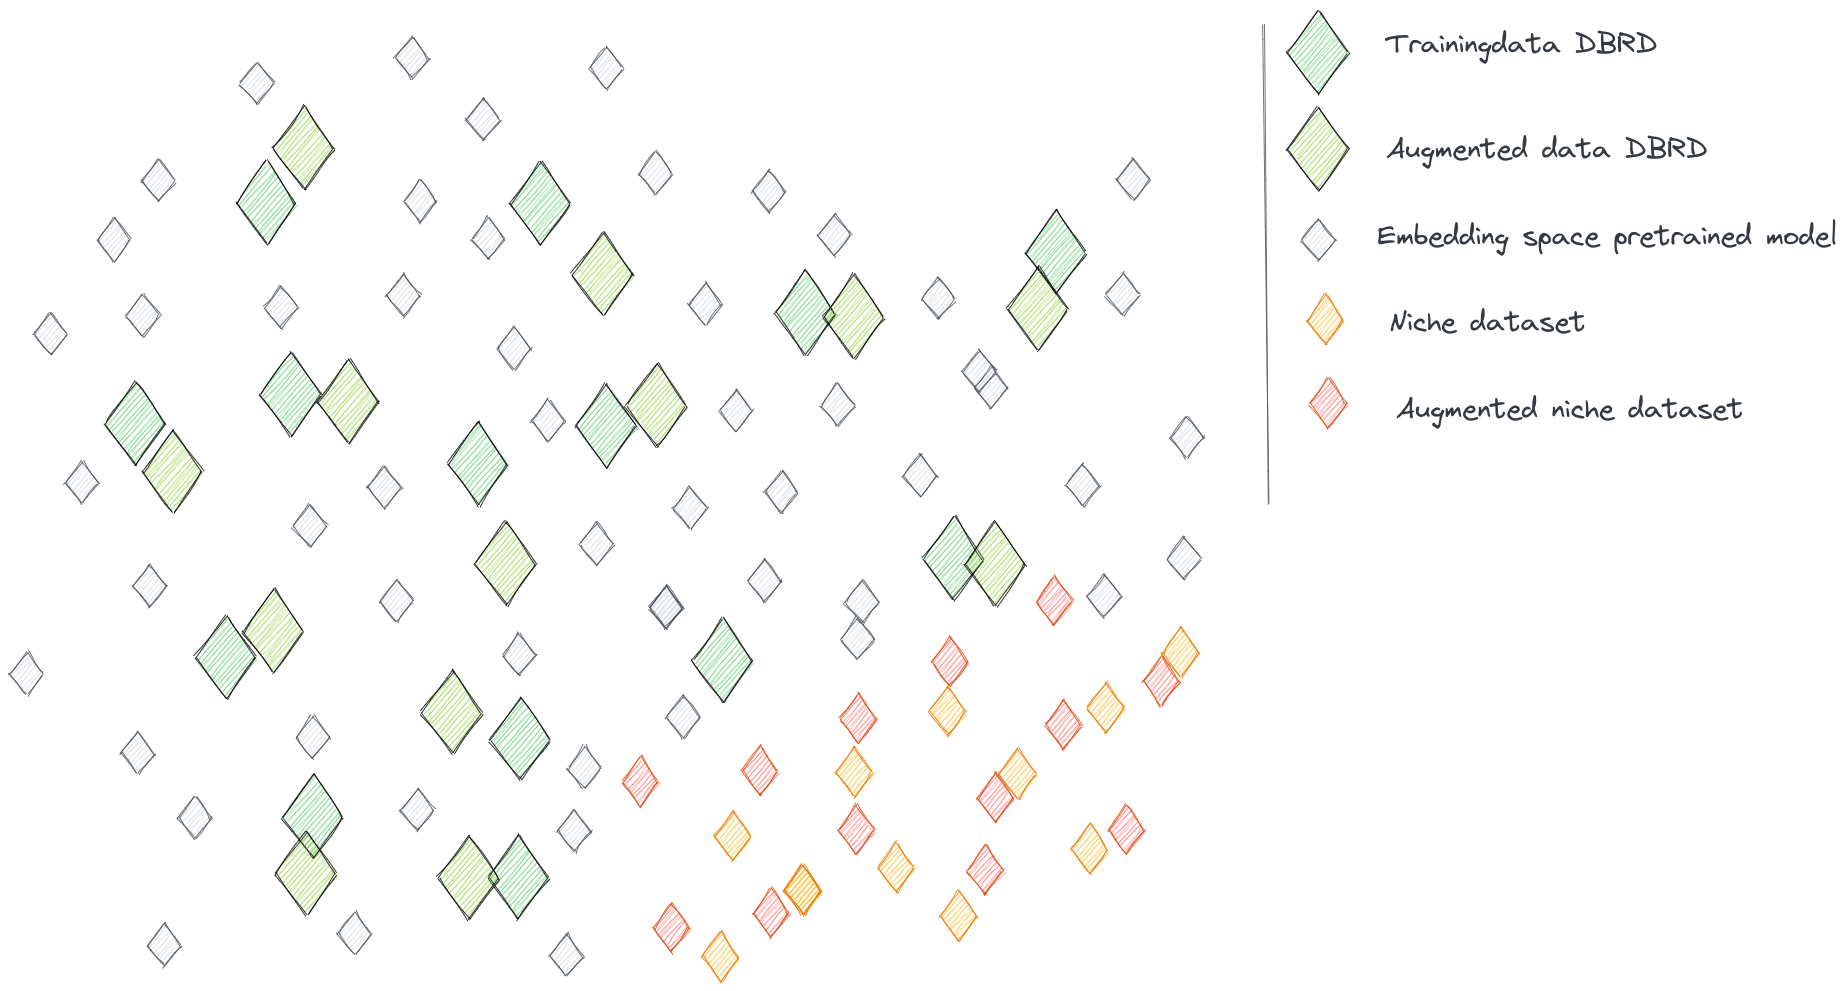